Продакт-менеджер Василий попросил вас проанализировать совершенные покупки и ответить на следующие вопросы:

1. Сколько у нас пользователей, которые совершили покупку только один раз?  

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? 

3. По каждому товару определить, в какой день недели товар чаще всего покупается. 

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. 

5. Напиши функцию на python, позволяющую строить когортный анализ. В период с января по декабрь выяви когорту с самым высоким retention на 3-й месяц. Описание подхода можно найти тут. 

6. Построй RFM-кластеры для пользователей. Выведи для каждого кластера средние значения метрик R, F, M (и опиши подробно, как были построены метрики R, F, M).
Файлы:

    olist_customers_datase.csv — таблица с уникальными идентификаторами пользователей\
customer_id — позаказный идентификатор пользователя (аналог номера паспорта)\
customer_unique_id —  уникальный идентификатор пользователя\
customer_zip_code_prefix —  почтовый индекс пользователя\
customer_city —  город доставки пользователя\
customer_state —  штат доставки пользователя

    olist_orders_dataset.csv —  таблица заказов\
order_id —  уникальный идентификатор заказа (номер чека)\
customer_id —  позаказный идентификатор пользователя (аналог номера паспорта)\
order_status —  статус заказа\
order_purchase_timestamp —  время создания заказа\
order_approved_at —  время подтверждения оплаты заказа\
order_delivered_carrier_date —  время передачи заказа в логистическую службу\
order_delivered_customer_date —  время доставки заказа\
order_estimated_delivery_date —  обещанная дата доставки

    olist_order_items_dataset.csv —  товарные позиции, входящие в заказы\
order_id —  уникальный идентификатор заказа (номер чека)\
order_item_id —  идентификатор товара внутри одного заказа\
product_id —  ид товара (аналог штрихкода)\
seller_id — ид производителя товара\
shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике\
price —  цена за единицу товара\
freight_value —  вес товара

— Пример структуры данных можно визуализировать по order_id == 00143d0f86d6fbd9f9b38ab440ac16f5

Уникальный статусы заказов в таблице olist_order_items_dataset:\
created —  создан\
approved —  подтверждён\
invoiced —  выставлен счёт\
processing —  в процессе сборки заказа\
shipped —  отгружен со склада\
delivered —  доставлен пользователю\
unavailable —  недоступен\
canceled —  отменён

In [248]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.colors as mcolors

import requests
import json
from urllib.parse import urlencode

import datetime as dt
import time

from operator import attrgetter
import warnings

In [249]:
# считаем данные
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'


olist_customers_datase_url          = 'https://disk.yandex.ru/d/FUi5uSd6BfG_ig'  
final_olist_customers_datase_url    = base_url + urlencode(dict(public_key=olist_customers_datase_url))
response_olist_customers_datase     = requests.get(final_olist_customers_datase_url)
json_olist_customers_datase         = json.loads(response_olist_customers_datase.text)['href']
customers                           = pd.read_csv(json_olist_customers_datase) 
                        # Таблица с уникальными идентификаторами пользователей

    
olist_orders_dataset_url            = 'https://disk.yandex.ru/d/t9Li4JOfgxuUrg'  
final_olist_orders_dataset_url      = base_url + urlencode(dict(public_key=olist_orders_dataset_url))
response_olist_orders_dataset       = requests.get(final_olist_orders_dataset_url)
json_olist_orders_dataset           = json.loads(response_olist_orders_dataset.text)['href']
orders                              = pd.read_csv(json_olist_orders_dataset) 
                        # Таблица заказов

    
olist_order_items_dataset_url       = 'https://disk.yandex.ru/d/Gbt-yAcQrOe3Pw'  
final_olist_order_items_dataset_url = base_url + urlencode(dict(public_key=olist_order_items_dataset_url))
response_olist_order_items_dataset  = requests.get(final_olist_order_items_dataset_url)
json_olist_order_items_dataset      = json.loads(response_olist_order_items_dataset.text)['href']
order_items                         = pd.read_csv(json_olist_order_items_dataset)  
                        # Товарные позиции, входящие в заказы


In [3]:
print('customers shape is -', customers.shape)
print('orders shape is -', orders.shape)
print('order_items shape is -', order_items.shape)

customers shape is - (99441, 5)
orders shape is - (99441, 8)
order_items shape is - (112650, 7)


##### 1. Сколько у нас пользователей, которые совершили покупку только один раз?

In [4]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [5]:
# Посмотрим пропущенные значения
orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [7]:
orders.order_status.unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

In [96]:
orders[~orders.order_status.isin(['created'])].shape

(99436, 8)

In [8]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [97]:
""" 
В датасете достаточно много статусов заказов, какой из них считать покупкой, зависит наверное от бизнеса и задачи.
Заказы со статусом 'created' будем считать не совершенной покупкой.
Так как в столбце даты оплаты, отсутствуют значения для уже доставленных заказов, 
видно что данные по времени некоторых столбцов где то внеслись, где то нет.
И в целом считаю это логичным решением.

Cоединяем с датасетом где есть уникальные айдишники, группируем, отбираем тех у кого 1 заказ и считаем количество уникальных

"""


purchases = (
    orders[~orders.order_status.isin(['created'])]
        .merge(
            customers[['customer_id','customer_unique_id']],
            on = 'customer_id',
            how = 'left'
        )\
        .groupby('customer_unique_id', as_index=False)
        .order_id
        .nunique()
        .query('order_id == 1')
        .customer_unique_id
        .nunique()
)

purchases

93096

##### 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

In [10]:
orders.dtypes # посмотрим формат данных

order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object

In [250]:
# преобразуем в формат даты
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])

# проверяем все ли получилось
orders.dtypes 

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                        object
order_delivered_carrier_date             object
order_delivered_customer_date            object
order_estimated_delivery_date            object
dtype: object

In [12]:
"""

Будем считать что заказы со статусом 'unavailable' и 'canceled' являются не доставленными, так как их описание
говорит само за себя.
Если смотреть по полю времени доставки, то там получается какая то каша. Есть заказы и со статусом в пути и со статусом
доставлено.
Отбираем по статусу, сортируем по дате, делаем ресемпл месяцу, считаем уникальные заказы в каждом месяце, выводим среднее
В некоторых месяцах у нас 0 заказов, у нас может быть множество причин почему они отсутствуют,
поэтому будем считать среднемесячное так, что бы не упустить эти месяца в группировке

"""
canceled = (
        orders[['order_purchase_timestamp','order_id','order_status']]
            .query('order_status == "canceled"')
            .sort_values('order_purchase_timestamp') 
            .set_index('order_purchase_timestamp') 
            .resample('M') 
            .nunique() 
            .order_id 
            .mean()
        )

unavailable = (
        orders[['order_purchase_timestamp','order_id','order_status']]
            .query('order_status == "unavailable"')
            .sort_values('order_purchase_timestamp') 
            .set_index('order_purchase_timestamp') 
            .resample('M') 
            .nunique() 
            .order_id 
            .mean()
        )

print(
    f'status canceled = {canceled}',
    f'status unavailable = {unavailable}', 
    sep='\n'
     )

status canceled = 24.03846153846154
status unavailable = 26.47826086956522


##### 3. По каждому товару определить, в какой день недели товар чаще всего покупается

In [13]:
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [98]:
"""

Как мы уже помним, что мы считаем покупкой, это те товары у которых нету времени оплаты и со статусом 'canceled' не считаем.
Из за этого после соединения датафреймов у нас отсутствуют данные по времени покупки на 15 товаров их мы убираем

"""

orders_with_product = (
    orders[~orders.order_status.isin(['created'])]
        .merge(
            order_items[['order_id','product_id']],
            on = 'order_id',
            how = 'right'
        )
        .dropna()
    )

orders_with_product['order_purchase_timestamp'] = (
    pd.to_datetime(orders_with_product['order_purchase_timestamp'])
    .dt.day_name()
    )

orders_with_product.rename(columns=({'order_purchase_timestamp':'weekday'}), inplace=True)

In [99]:
"""

Группируем по товару, применяем собственную агрегационную функцию, которая выводит нам максимально встречающиеся 
значения(т.е. моды), приводим в вид датафрейма и сбрасываем индексы.

"""

max_count_weekday_purchases_for_product = (
                                        orders_with_product
                                            .groupby('product_id')
                                            .weekday
                                            .agg(lambda x: x.mode())
                                            .to_frame()
                                            .reset_index()
                                        )

max_count_weekday_purchases_for_product.head()

,product_id,weekday
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday
1,00088930e925c41fd95ebfe695fd2655,Tuesday
2,0009406fd7479715e4bef61dd91f2462,Thursday
3,000b8f95fcb9e0096488278317764d19,"[Friday, Wednesday]"
4,000d9be29b5207b54e86aa1b1ac54872,Tuesday


##### 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? 
##### Не стоит забывать, что внутри месяца может быть не целое количество недель. 
##### Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

In [159]:
"""

Соединяем таблицы заказов и уникальных покупателей;
Создаем столбец с месяцем покупки;
Группируемся по уникальным покупателям и месяцам покупки и считаем заказы в месяце по каждому покупателю;
Преобразуем дату, создаем столбец с количеством дней в месяце;
И считаем сколько в среднем каждый пользователь покупал в неделю.

"""


orders_and_uniqe_customers = (
    orders[~orders.order_status.isin(['created'])]
        .merge(
            customers[['customer_id',
                       'customer_unique_id']],
            on = 'customer_id',
            how = 'left'
        )
)

orders_and_uniqe_customers['month'] = (
                                    orders_and_uniqe_customers['order_purchase_timestamp']
                                        .apply(lambda x: x.strftime('%Y-%m'))
                                    )


orders_and_uniqe_customers = (
                        orders_and_uniqe_customers
                            .groupby(['customer_unique_id','month'], as_index=False)
                            .agg({'order_id':'count'})
                        )

orders_and_uniqe_customers['month']                  = pd.to_datetime(orders_and_uniqe_customers['month'])
orders_and_uniqe_customers['day_in_month']           = orders_and_uniqe_customers.month.dt.daysinmonth / 7

orders_and_uniqe_customers['mean_purchases_of_weak'] = (orders_and_uniqe_customers.order_id 
                                                        /
                                                        orders_and_uniqe_customers.day_in_month)


orders_and_uniqe_customers[['customer_unique_id','month','mean_purchases_of_weak']].head()

,customer_unique_id,month,mean_purchases_of_weak
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,0.225806
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-01,0.225806
2,0000f46a3911fa3c0805444483337064,2017-03-01,0.225806
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-01,0.225806
4,0004aac84e0df4da2b147fca70cf8255,2017-11-01,0.233333


##### 5. Напиши функцию на python, позволяющую строить когортный анализ. В период с января по декабрь выяви когорту с самым высоким retention на 3-й месяц. Описание подхода можно найти тут.

In [353]:
def retention(df_retantion):
    
"""

Функция на вход принимает датафрейм с колонками customer, order_id, date.
И выводит график ретеншена с хитмапом.

"""


    df = (
          df_retantion[['customer', 
                        'order_id', 
                        'date']]
          .drop_duplicates()
    )
    
    
    df['order_month'] = df['date'].dt.to_period('M')
    df['cohort'] = (
                    df.groupby('customer')['date'] 
                        .transform('min') 
                        .dt.to_period('M') 
    )

    df_cohort = (
                df.groupby(['cohort', 'order_month'])
                  .agg(n_customers=('customer', 'nunique')) 
                  .reset_index(drop=False)
    )
    df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))

    cohort_pivot = df_cohort.pivot_table(index = 'cohort',
                                         columns = 'period_number',
                                         values = 'n_customers')

    cohort_size = cohort_pivot.iloc[:,0]
    
    retention_matrix = (
                        cohort_pivot
                            .divide(cohort_size, axis = 0)
                            .drop(columns={0})
    )


    with sns.axes_style("white"):
        fig, ax = plt.subplots(1, 2, figsize=(16, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})

        # retention matrix
        sns.heatmap(retention_matrix, 
                    mask=retention_matrix.isnull(), 
                    annot=True, 
                    fmt='.2%', 
                    cmap='Greens', 
                    ax=ax[1])
        ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16)
        ax[1].set(xlabel='number of periods',
                  ylabel='')

        # cohort size
        cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
        white_cmap = mcolors.ListedColormap(['white'])
        img = sns.heatmap(cohort_size_df, 
                    annot=True, 
                    cbar=False, 
                    fmt='g', 
                    cmap=white_cmap, 
                    ax=ax[0])

        fig.tight_layout()
        
        return img

In [409]:
"""

Подготавливаем датафрейм для применения функции retantion

"""


retention_for_cohort_analysys = (
                                orders[['customer_id',
                                        'order_id',
                                        'order_purchase_timestamp']]
                                    .merge(
                                        customers[['customer_id',
                                                   'customer_unique_id']], 
                                        on='customer_id', 
                                        how='left'
                                    )
)



retention_for_cohort_analysys = (
                                retention_for_cohort_analysys[['customer_unique_id',
                                                               'order_id', 
                                                               'order_purchase_timestamp']]
                                    .rename(columns={'customer_unique_id':'customer', 
                                                     'order_purchase_timestamp':'date'})
)


In [410]:
"""

Так как данные за полный год у нас есть только за 2017 год
То тут мы всех пользователей кто был до 2017 года вносим в кагорту января 2017
И так как нам нужно выявить когорту с января по декабрь с самым высоким ретеншеном на 3 месяц, то оставляем данные за 4 месяца
2018 года

"""

cohort_2017_01 = retention_for_cohort_analysys.query('date < "2017-01-01"')
cohort_2017_01['date'] = '2017-01-01'

retention_for_cohort_analysys = (
                                pd.concat([cohort_2017_01, 
                                           retention_for_cohort_analysys.query('date > "2017-01-01"')])
                                .reset_index()
                                )

retention_for_cohort_analysys['date'] = pd.to_datetime(retention_for_cohort_analysys['date'])

retention_for_cohort_analysys.query('date < "2018-04-01"', inplace=True)

C:\Users\smars\AppData\Local\Temp\ipykernel_17432\3905294554.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cohort_2017_01['date'] = '2017-01-01'


<AxesSubplot:ylabel='cohort'>

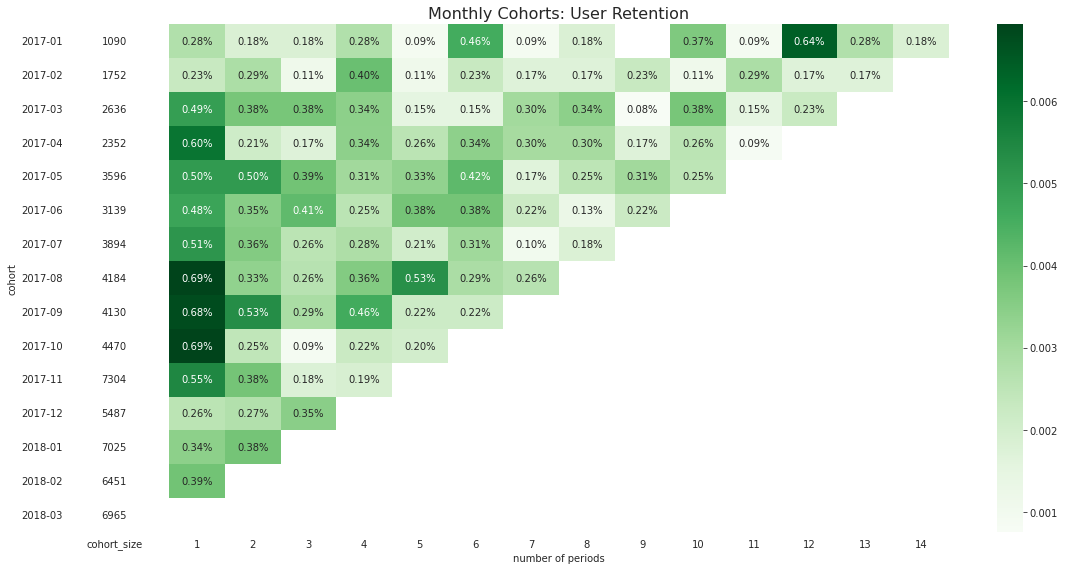

In [404]:
"""

Когорта 2017-06 имеет самый высокий ретеншен - 0.41%

"""

retention(retention_for_cohort_analysys)

##### 6. Построй RFM-кластеры для пользователей. Выведи для каждого кластера средние значения метрик R, F, M (и опиши подробно, как были построены метрики R, F, M).

In [5]:
"""

Соединяем всю информацию в один датафрейм для подсчетов метрик.
Определяем переменную max_date для расчета метрики recency.
Группируем по уникальному покупателю и в агрегации считаем метрики.

"""


rfm_data = (
            order_items
                .groupby(['order_id'], as_index=False)
                .agg({'price': sum})
                .merge(
                        orders[['order_id',
                                'order_purchase_timestamp',
                                'customer_id',
                                'order_status']], 
                        on='order_id'
                )
    
                .merge(
                        customers[['customer_id',
                                   'customer_unique_id']], 
                        on='customer_id'
                )
    
                [['customer_unique_id',
                  'order_id',
                  'order_purchase_timestamp',
                  'price', 
                  'order_status']]
    
)

max_date = max(rfm_data.order_purchase_timestamp) + dt.timedelta(days=1)

rfm_data = (
            rfm_data[~rfm_data.order_status.isin(['created'])]
                .groupby('customer_unique_id', as_index=False)
                .agg({'order_purchase_timestamp': lambda x: (max_date- x.max()).days, 
                      'order_id': 'count', 
                      'price': 'sum'})
    
                .rename(columns= {'order_purchase_timestamp': 'recency', 
                                  'order_id': 'frequency', 
                                  'price': 'monetary'})
)

rfm_data.head()

,customer_unique_id,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90
2,0000f46a3911fa3c0805444483337064,542,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,293,1,180.00


<AxesSubplot:xlabel='recency', ylabel='Count'>

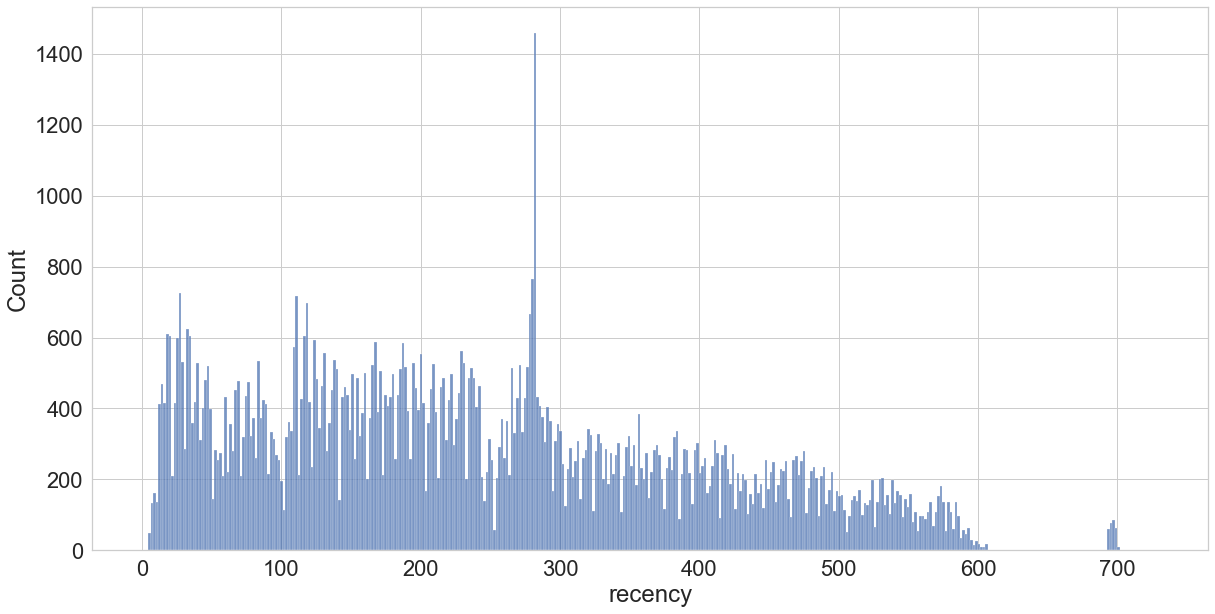

In [43]:
"""

Посмотрим как у нас распределились метрики.

"""

sns.set(
    font_scale=2,
    style="whitegrid",
    rc={'figure.figsize':(20,10)}
        )

sns.histplot(
    data=rfm_data, 
    x="recency",
    bins=400
            )

<AxesSubplot:xlabel='frequency', ylabel='Count'>

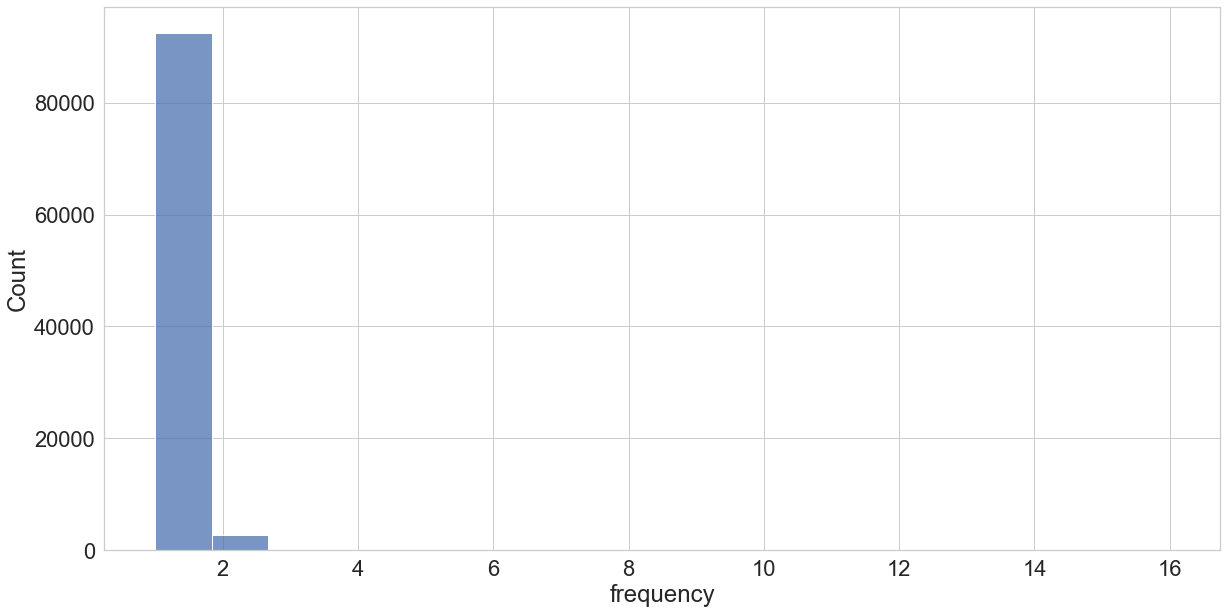

In [232]:
sns.histplot(
    data=rfm_data, 
    x="frequency"
            )

<AxesSubplot:xlabel='monetary', ylabel='Count'>

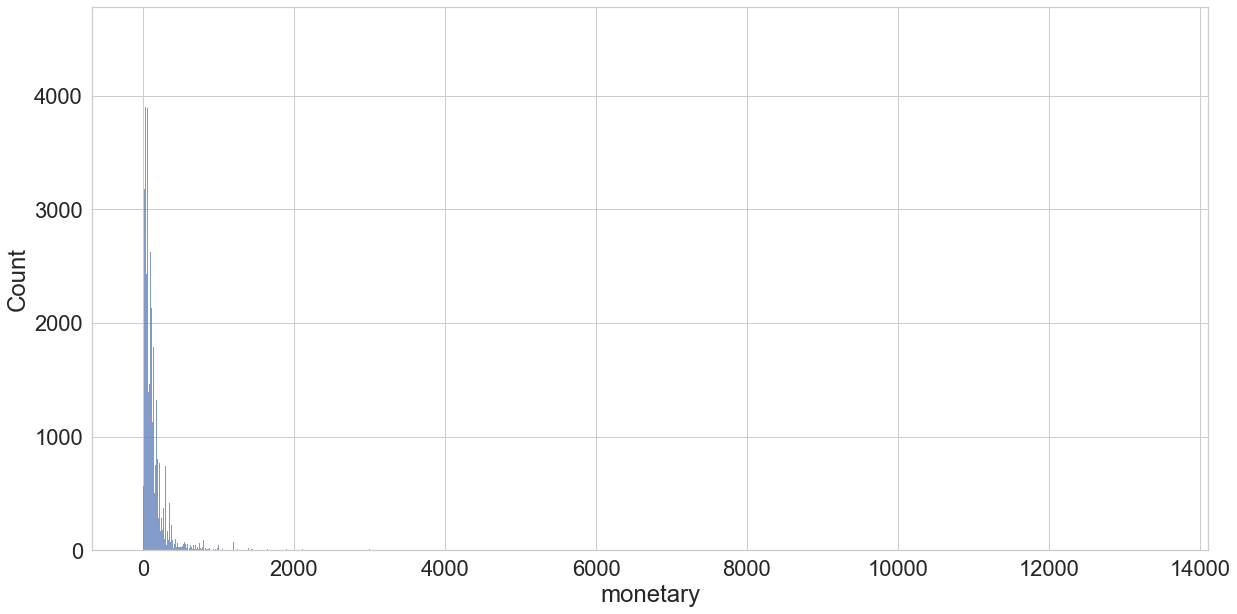

In [35]:
sns.histplot(
    data=rfm_data, 
    x="monetary"
            )

<AxesSubplot:xlabel='monetary', ylabel='Count'>

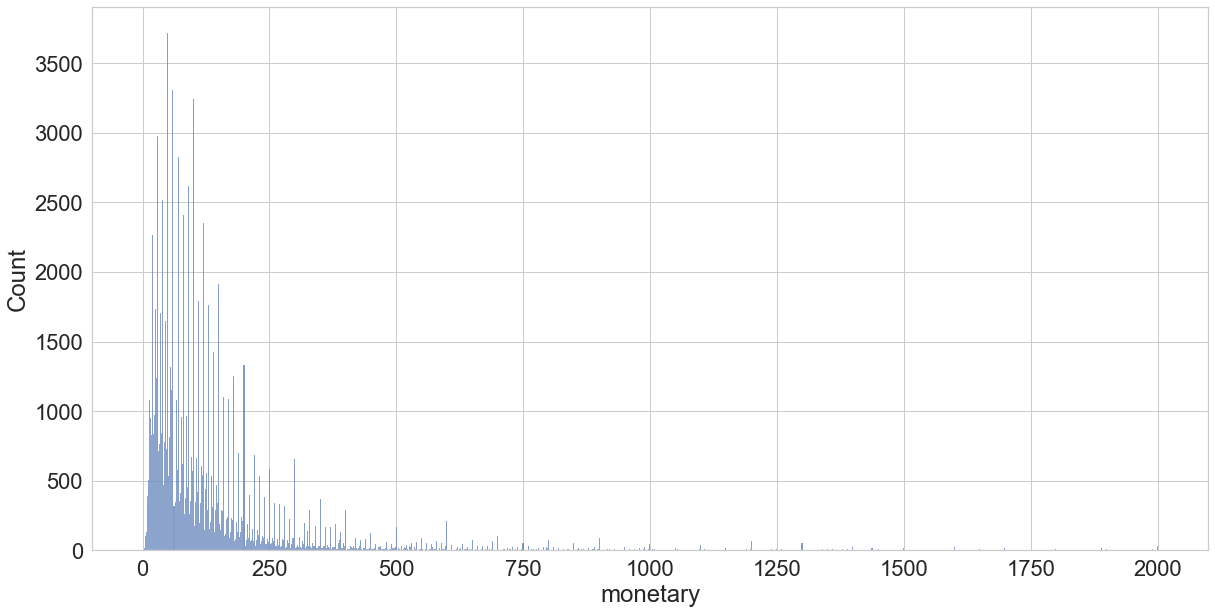

In [55]:
sns.histplot(
    data=rfm_data.query('monetary < 2000'), 
    x="monetary", 
    bins=1000
            )

<AxesSubplot:xlabel='monetary', ylabel='Count'>

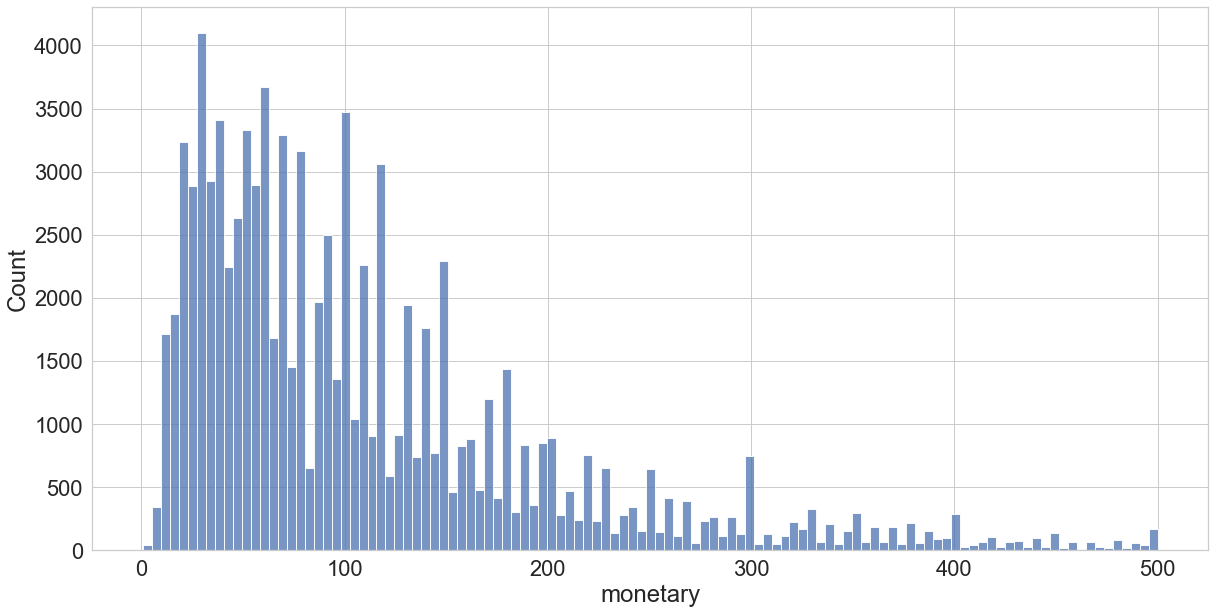

In [56]:
sns.histplot(
    data=rfm_data.query('monetary < 500'), 
    x="monetary"
            )

In [231]:
"""

Сделаем это просто по квантилям.
А из за того что у нас основная масса пользователей совершила покупку 1 раз, мы поделим метрику F вручную

"""

rfm_data['R'] = (
                pd.qcut(rfm_data['recency'], 
                        q=4, 
                        labels=['4','3','2','1'])
                .astype(str)
)

rfm_data['F'] = (
                pd.cut(
                    rfm_data['frequency'], 
                       bins=[0,1,5,50], 
                       labels=[1,2,3])
                .astype(str)
)

rfm_data['M'] = (
                pd.qcut(rfm_data['monetary'], 
                        q=4, 
                        labels=['1','2','3','4'])
                .astype(str)
)

rfm_data['RFM'] = rfm_data.R + rfm_data.F + rfm_data.M

rfm_data.head()

,customer_unique_id,recency,frequency,monetary,R,F,M,RFM
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,4,1,3,413
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,4,1,1,411
2,0000f46a3911fa3c0805444483337064,542,1,69.00,1,1,2,112
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,2,1,1,211
4,0004aac84e0df4da2b147fca70cf8255,293,1,180.00,2,1,4,214


In [247]:
"""

Выведем для каждого кластера среднее значение метрик

"""

cluster_metrics_mean = ( 
                        rfm_data
                            .groupby('RFM', as_index=False)
                            .agg({'recency':'mean','frequency':'mean','monetary':'mean'})
)

cluster_metrics_mean

,RFM,recency,frequency,monetary
0,111,461.200296,1.000000,29.006379
1,112,453.596933,1.000000,66.897246
2,113,459.156952,1.000000,118.139236
3,114,461.011794,1.000000,363.995348
4,121,485.971429,2.142857,34.154000
5,122,452.088889,2.044444,70.572778
6,123,446.155844,2.058442,123.141169
7,124,440.191950,2.083591,387.554056
8,132,606.000000,6.000000,58.400000
9,211,282.461525,1.000000,29.124553


In [246]:
"""

Запишем диапазоны в переменные.
И создадим столбец с описанием метрик

"""


r_discription = list(rfm_data.recency.describe()[3:].astype(int))
f_discription = [1,2,5]
m_discription = list(rfm_data.monetary.describe()[3:].astype(int))

cluster_metrics_mean['discription'] = (
    
    (cluster_metrics_mean['RFM']
        .apply(
               lambda x: 
                        f'Более {r_discription[3]} дней назад' if x[0]=='1'else
                            (f'{r_discription[2]} - {r_discription[3]-1} дней назад' if x[0]=='2' else
                                (f'{r_discription[1]} - {r_discription[2]-1} дней назад' if x[0]=='3' else
                                    f'Менее {r_discription[1]} дней назад')))) 
    +
    
    (cluster_metrics_mean['RFM']
        .apply(
               lambda x: 
                        f' покупал {f_discription[0]} раз' if x[1]=='1'else
                            (f' покупал {f_discription[1]} - {f_discription[2]} раз' if x[1]=='2' else
                                f' покупал более {f_discription[2]+1} раз' )))
    +
    
    (cluster_metrics_mean['RFM']
        .apply(
               lambda x: 
                    f' на {m_discription[0]} до {m_discription[1]}' if x[2]=='1'else
                        (f' на {m_discription[1]} до {m_discription[2]}' if x[2]=='2' else
                            (f' {m_discription[2]} до {m_discription[3]}' if x[2]=='3' else
                                f' на сумму от {m_discription[3]}'))))
)

metrics_discription = cluster_metrics_mean[['RFM','discription']]
metrics_discription

,RFM,discription
0,111,Более 353 дней назад покупал 1 раз на 0 до 47
1,112,Более 353 дней назад покупал 1 раз на 47 до 89
2,113,Более 353 дней назад покупал 1 раз 89 до 155
3,114,Более 353 дней назад покупал 1 раз на сумму от...
4,121,Более 353 дней назад покупал 2 - 5 раз на 0 до 47
5,122,Более 353 дней назад покупал 2 - 5 раз на 47 д...
6,123,Более 353 дней назад покупал 2 - 5 раз 89 до 155
7,124,Более 353 дней назад покупал 2 - 5 раз на сумм...
8,132,Более 353 дней назад покупал более 6 раз на 47...
9,211,224 - 352 дней назад покупал 1 раз на 0 до 47
